# DEEP LEARNING with PyTorch: NEURAL STYLE TRANSFER

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## LOAD VGG

In [3]:
import torch
from torchvision import models

vgg=models.vgg19(pretrained=True)
#print(vgg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
vgg=vgg.features # We only need features.
#print(vgg)

In [5]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Preprocess Image

In [8]:
from PIL import Image
from torchvision import transforms as T
def preprocess(img_path,max_size=500):
    image=Image.open(img_path).convert("RGB")
    
    if max(image.size) > max_size:
        size=max_size
    else:
        size=max(image.size)
    
    img_transforms = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485,0.456,0.406],
            std=[0.229,0.224,0.225]
        )
    ])
    
    image=img_transforms(image)
    image=image.unsqueeze(0)
    return image

In [9]:
content_p=preprocess("/content/images/me3.jpeg")
style_p=preprocess("/content/images/style2.jpg")
content_p=content_p.to(device)
style_p=style_p.to(device)

In [10]:
print("Process Content Shape: ",content_p.shape)
print("Process Style Shape: ",style_p.shape)

Process Content Shape:  torch.Size([1, 3, 500, 542])
Process Style Shape:  torch.Size([1, 3, 500, 686])


## Deprocess Image

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
def deprocess(tensor):
    image=tensor.to("cpu").clone()
    image=image.numpy()
    image=image.squeeze(0)
    image=image.transpose(1,2,0)
    image=image * np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406])
    image=image.clip(0,1)
    
    return image

In [13]:
content_d=deprocess(content_p)
style_d=deprocess(style_p)

In [14]:
print("Deprocess Content Shape: ",content_d.shape)
print("Deprocess Style Shape: ",style_d.shape)

Deprocess Content Shape:  (500, 542, 3)
Deprocess Style Shape:  (500, 686, 3)


## PLOT IMAGES

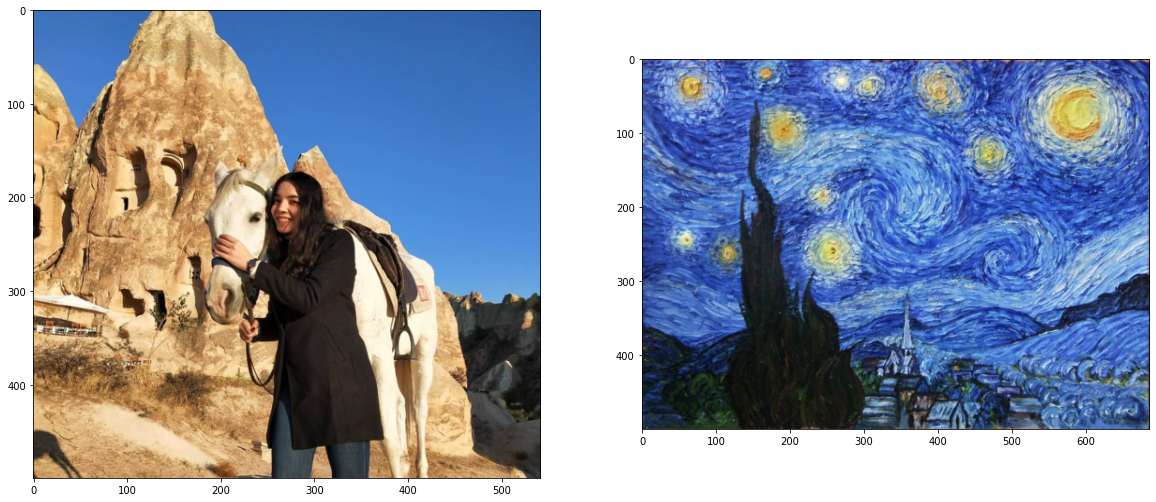

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

## Features

In [16]:
def get_features(image,model):

  layers= {
      
      "0":"conv1_1",
      "5":"conv2_1",
      "10":"conv3_1",
      "19":"conv4_1",
      "21":"conv4_2",
      "28":"conv5_1"
  }
  x=image
  Features={}

  for name,layer in model._modules.items():
    x=layer(x)

    if name in layers:
      Features[layers[name]]=x
  return Features

In [17]:
content_f=get_features(content_p,vgg)
style_f=get_features(style_p,vgg)

## GRAM MATRIX

In [18]:
def gram_matrix(tensor):
  # batch_size,channel,height,width
  b,c,h,w =tensor.size()
  tensor=tensor.view(c,h*w)
  gram=torch.mm(tensor,tensor.t())
  return gram

In [19]:
style_grams={layer : gram_matrix(style_f[layer]) for layer in style_f}

## Loss Function & Style

In [20]:
def content_loss(target_conv4_2,content_conv4_2):
  loss=torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [21]:
style_weights={
    
    "conv1_1":1.0,
    "conv2_1":0.75,
    "conv3_1":0.2,
    "conv4_1":0.2,
    "conv5_1":0.2
    
}

In [22]:
def style_loss(style_weights,target_features,style_grams):
  loss=0

  for layer in style_weights:
    target_f=target_features[layer]
    target_gram=gram_matrix(target_f)
    style_gram=style_grams[layer]
    b,c,h,w=target_f.shape
    layer_loss=style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    loss+=layer_loss/(c*h*w)
  return loss

In [23]:
target=content_p.clone().requires_grad_(True).to(device)
target_f=get_features(target,vgg)
print("Content Loss: ",content_loss(target_f["conv4_2"],content_f["conv4_2"]))
print("Style Loss: ",style_loss(style_weights,target_f,style_grams))

Content Loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss:  tensor(1077.3721, device='cuda:0', grad_fn=<AddBackward0>)


# Training

In [24]:
from torch import optim

optimizer=optim.Adam([target],lr=0.003)
alpha=1
betha=1e5

epochs=100000
show_every=500

In [25]:
def total_loss(c_loss,s_loss,alpha,betha):
  loss=alpha*c_loss+betha*s_loss
  return loss

In [26]:
results=[]

for i in range(epochs):
  target_f=get_features(target,vgg)

  c_loss=content_loss(target_f["conv4_2"],content_f["conv4_2"])
  s_loss=style_loss(style_weights,target_f,style_grams)
  t_loss=total_loss(c_loss,s_loss,alpha,betha)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every==0:
    print("Total Loss at Epoch: {} : {} ".format(i,t_loss))
    results.append(deprocess(target.detach()))

Total Loss at Epoch: 0 : 107737208.0 
Total Loss at Epoch: 500 : 3943054.25 
Total Loss at Epoch: 1000 : 1284800.625 
Total Loss at Epoch: 1500 : 644760.0 
Total Loss at Epoch: 2000 : 405761.96875 
Total Loss at Epoch: 2500 : 275659.09375 
Total Loss at Epoch: 3000 : 196358.796875 
Total Loss at Epoch: 3500 : 146750.421875 
Total Loss at Epoch: 4000 : 114617.5390625 
Total Loss at Epoch: 4500 : 92711.546875 
Total Loss at Epoch: 5000 : 76805.125 
Total Loss at Epoch: 5500 : 64940.765625 
Total Loss at Epoch: 6000 : 55934.52734375 
Total Loss at Epoch: 6500 : 48983.15234375 
Total Loss at Epoch: 7000 : 43613.734375 
Total Loss at Epoch: 7500 : 39405.91015625 
Total Loss at Epoch: 8000 : 36094.5703125 
Total Loss at Epoch: 8500 : 33515.4765625 
Total Loss at Epoch: 9000 : 31517.140625 
Total Loss at Epoch: 9500 : 29901.615234375 
Total Loss at Epoch: 10000 : 28643.955078125 
Total Loss at Epoch: 10500 : 27650.994140625 
Total Loss at Epoch: 11000 : 26800.1875 
Total Loss at Epoch: 11500 

ValueError: ignored

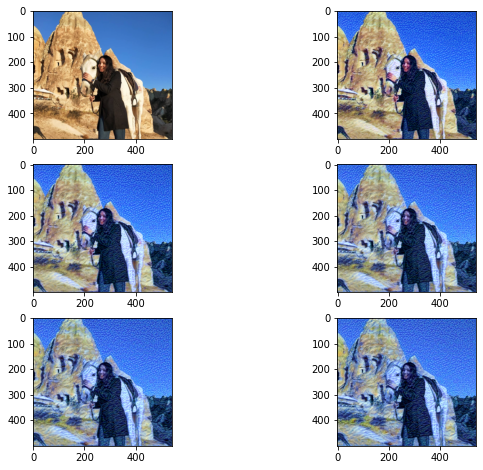

In [27]:
plt.figure(figsize=(10,8))

for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

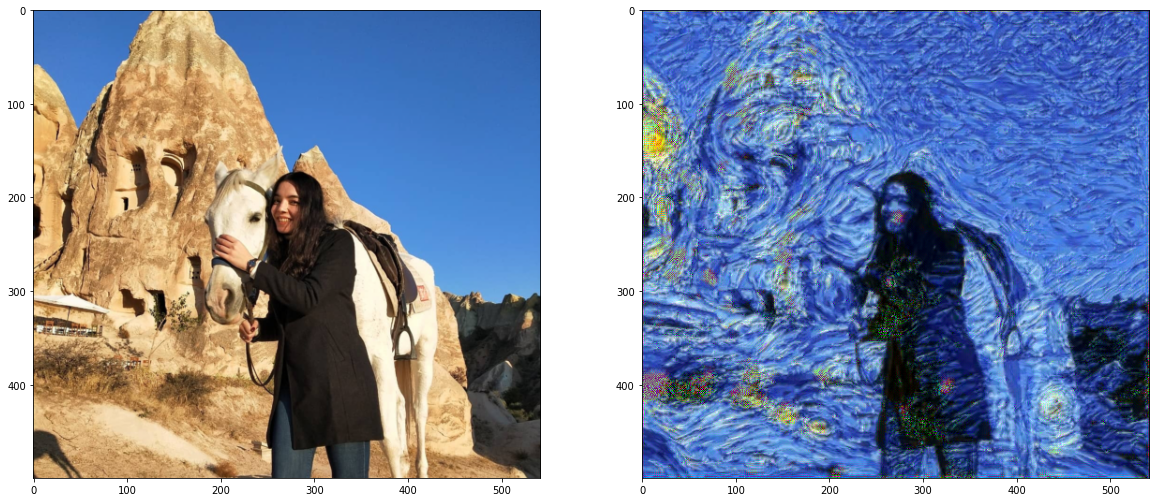

In [28]:
target_copy=deprocess(target.detach())
content_copy=deprocess(content_p)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_copy)
ax2.imshow(target_copy)
plt.show()